# RECSYS COMPETITION - 1st place

In [1]:
LOAD_MODELS = False

# Importing the repo

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("token")

!git clone https://{token}@github.com/Benedart/RecSys-2022-Challenge-Polimi.git

Cloning into 'RecSys-2022-Challenge-Polimi'...
remote: Enumerating objects: 659, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 659 (delta 20), reused 34 (delta 11), pack-reused 615
Receiving objects: 100% (659/659), 1.10 GiB | 31.04 MiB/s, done.
Resolving deltas: 100% (286/286), done.


In [3]:
import os

os.chdir( "./RecSys-2022-Challenge-Polimi")

In [4]:
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from MatrixFactorization_Cython_Epoch.c:746:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization_Cyth

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps
import csv
from tqdm import tqdm

from Recommenders.Recommender_import_list import *

## Data Import and Preprocessing

Import dataframes

In [6]:
URM_all = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/interactions_and_impressions.csv")
ICM_type = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_type.csv")
ICM_length = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_length.csv")

ICM_all = pd.concat([ICM_type, ICM_length]).sort_values(by='item_id')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
URM_all.head(5)

,UserID,ItemID,Impressions,Data
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,21,NaN,0
2,0,21,NaN,0
3,0,21,"20,21,22,23,24,25,26,27,28,29",0
4,0,21,NaN,1


### Data = 0 => Watched

### Data = 1 => Clicked

In [8]:
print("Items with type are {}".format(len(ICM_type)))
print("Items with length are {}".format(len(ICM_length)))
print("Items in the urm are {}".format(len(URM_all["ItemID"].unique())))

Items with type are 23091
Items with length are 23091
Items in the urm are 24507


#### Let's remove items that don't appear in the urm

In [9]:
users_URM = pd.DataFrame({"UserID": URM_all["UserID"].unique()})
users_URM.head(15)

,UserID
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [10]:
items_URM = pd.DataFrame({"item_id": URM_all["ItemID"].unique()})
items_URM

,item_id
0,11
1,21
2,22
3,24
4,44
...,...
24502,19714
24503,19075
24504,20006
24505,20177


In [11]:
all_items_ICM = pd.DataFrame({"item_id": ICM_all["item_id"].unique()})
all_items_ICM

,item_id
0,0
1,1
2,2
3,3
4,4
...,...
23086,27963
23087,27964
23088,27965
23089,27966


In [12]:
relevant_ICM_items = items_URM.merge(all_items_ICM, on="item_id")

relevant_ICM_items

,item_id
0,11
1,21
2,22
3,44
4,54
...,...
19625,13608
19626,21627
19627,19714
19628,20006


In [13]:
relevant_ICM = relevant_ICM_items.merge(ICM_all, on="item_id", how="left")
relevant_ICM  # these are the only features we want to care about

,item_id,feature_id,data
0,11,0,1
1,11,1,1
2,21,4,1
3,21,0,27
4,22,2,1
...,...,...,...
39255,19714,0,3
39256,20006,3,1
39257,20006,0,1
39258,20177,0,3


In [14]:
mapped_id, original_id = pd.factorize(URM_all["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)
print("Unique UserID in the URM are {}".format(len(original_id)))

mapped_id, original_id = pd.factorize(URM_all["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

feature_original_ID_to_index = pd.Series({
    0: 5,
    1: 0,
    2: 2,
    3: 3,
    7: 1,
    4: 4
}, index = [0, 1, 2, 3, 4, 7]) # feature id mapping

print("Unique FeatureID in the URM are {}".format(len(feature_original_ID_to_index)))

URM_all["UserID"] = URM_all["UserID"].map(user_original_ID_to_index)
URM_all["ItemID"] = URM_all["ItemID"].map(item_original_ID_to_index)
relevant_ICM["item_id"] = relevant_ICM["item_id"].map(item_original_ID_to_index)
relevant_ICM["feature_id"] = relevant_ICM["feature_id"].map(feature_original_ID_to_index)

Unique UserID in the URM are 41629
Unique FeatureID in the URM are 6


In [15]:
URM_all

,UserID,ItemID,Impressions,Data
0,0,0,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,1,NaN,0
2,0,1,NaN,0
3,0,1,"20,21,22,23,24,25,26,27,28,29",0
4,0,1,NaN,1
...,...,...,...,...
5826501,41628,3700,NaN,0
5826502,41628,12694,NaN,1
5826503,41628,15132,NaN,1
5826504,41628,18128,NaN,0


In [16]:
relevant_ICM

,item_id,feature_id,data
0,0,5,1
1,0,0,1
2,1,4,1
3,1,5,27
4,2,2,1
...,...,...,...
39255,24502,5,3
39256,24504,3,1
39257,24504,5,1
39258,24505,5,3


In [17]:
ICM_all = relevant_ICM
ICM_all

,item_id,feature_id,data
0,0,5,1
1,0,0,1
2,1,4,1
3,1,5,27
4,2,2,1
...,...,...,...
39255,24502,5,3
39256,24504,3,1
39257,24504,5,1
39258,24505,5,3


---------

## Define User-Items to bonus/malus

In [18]:
def subtract_dfs(df1, df2):
    result = pd.merge(df1, df2, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    return result

In [19]:
def get_bonus_fakemalus_realmalus(u):
    DF_Clicked = u[u["Data"] == 1].drop(["Impressions"], axis=1)
    DF_Clicked = DF_Clicked.groupby(['UserID', 'ItemID'], as_index=False).count()
    DF_Clicked.rename(inplace=True, columns={"Data": "Clicked"})
    DF_Watched = u[u["Data"] == 0].drop(["Impressions"], axis=1)
    DF_Watched = DF_Watched.groupby(['UserID', 'ItemID'], as_index=False).count()
    DF_Watched.rename(inplace=True, columns={"Data": "Watched"})
    
    # find bonus: interactiors that are both watched and clicked
    comparison_df = DF_Watched.merge(DF_Clicked, on=["UserID", "ItemID"])
    comparison_df = comparison_df.drop(["Clicked", "Watched"], axis=1)
    bonus = np.array((comparison_df.UserID, comparison_df.ItemID))
    
    # fake malus: interactions that have been only watched
    Watched_once_df = DF_Watched[DF_Watched["Watched"]==1]
    Fake_Malus_df = subtract_dfs(Watched_once_df.drop(["Watched"], axis=1), DF_Clicked.drop(["Clicked"], axis=1))
    fake_malus = np.array((Fake_Malus_df.UserID, Fake_Malus_df.ItemID))
    
    # real malus: interactions that have been only clicked
    Clicked_once_df = DF_Clicked[DF_Clicked["Clicked"]==1]
    Real_Malus_df = subtract_dfs(Clicked_once_df.drop(["Clicked"], axis=1), DF_Watched.drop(["Watched"], axis=1))
    real_malus = np.array((Real_Malus_df.UserID, Real_Malus_df.ItemID))

    return bonus, fake_malus, real_malus

In [20]:
both_watched_and_clicked, only_watched_once, only_clicked_once = get_bonus_fakemalus_realmalus(URM_all)

In [21]:
both_watched_and_clicked, only_watched_once, only_clicked_once

(array([[    0,     0,     0, ..., 41617, 41624, 41624],
        [    1,    13,    15, ...,   487,  1384,  5463]]),
 array([[    0,     0,     0, ..., 41628, 41628, 41628],
        [    6,    11,    25, ..., 18128, 19540, 20960]]),
 array([[    0,     0,     0, ..., 41628, 41628, 41628],
        [    0,     3,     4, ..., 17163, 18725, 22724]]))

In [22]:
def get_modified_urm(urm_original, bonus_amount, bonus_interactions):     # malus negativi!!!!
    bonus_length = bonus_interactions.shape[1]
       
        
    urm_copy = urm_original.copy()
    
    for i in range(0, bonus_length):
        x = urm_copy[bonus_interactions[0][i], bonus_interactions[1][i]]
        if (x!=0): urm_copy[bonus_interactions[0][i], bonus_interactions[1][i]] += bonus_amount
            
    
    return urm_copy

---------

## Creating the matrixces

In [23]:
URM_all_binary = URM_all.drop(["Impressions", "Data"], axis=1).drop_duplicates()

In [24]:
URM_all_binary["Rating"]=1.0
URM_all_binary

,UserID,ItemID,Rating
0,0,0,1.0
1,0,1,1.0
13,0,2,1.0
28,0,3,1.0
29,0,4,1.0
...,...,...,...
5826501,41628,3700,1.0
5826502,41628,12694,1.0
5826503,41628,15132,1.0
5826504,41628,18128,1.0


In [25]:
ICM_all["feature_id"].unique()

array([5, 0, 4, 2, 3, 1])

In [26]:
n_users = len(user_original_ID_to_index)
n_items = len(item_original_ID_to_index)
n_features = len(feature_original_ID_to_index)

print("Number of users is {}".format(n_users))
print("Number of items is {}".format(n_items))
print("Number of features is {}".format(n_features))

from sklearn.model_selection import train_test_split
seed = 42

(user_ids_training, user_ids_validation,
 item_ids_training, item_ids_validation,
 ratings_training, ratings_validation) = train_test_split(URM_all_binary.UserID,
                                                        URM_all_binary.ItemID,
                                                        URM_all_binary.Rating,
                                                        test_size=0.15,
                                                        shuffle=True,
                                                        random_state=seed)

urm_train = sps.csr_matrix((ratings_training, (user_ids_training, item_ids_training)),
                           shape = (n_users, n_items))

urm_validation = sps.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)),
                           shape = (n_users, n_items))

urm_all = sps.csr_matrix((URM_all_binary.Rating, (URM_all_binary.UserID, URM_all_binary.ItemID)),
                           shape = (n_users, n_items))

icm_all = sps.csr_matrix((np.ones(len(ICM_all["item_id"].values)), 
                          (ICM_all["item_id"].values, ICM_all["feature_id"].values)),
                        shape = (n_items, 6))

icm_all.data = np.ones_like(icm_all.data)

icm_all = sps.csr_matrix(icm_all)
features_per_item = np.ediff1d(icm_all.indptr)

icm_all = sps.csc_matrix(icm_all)
items_per_feature = np.ediff1d(icm_all.indptr)

icm_all = sps.csr_matrix(icm_all)        # come maaaaiiiii?????

urm_train, urm_validation, urm_all, icm_all

Number of users is 41629
Number of items is 24507
Number of features is 6


(<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 1321444 stored elements in Compressed Sparse Row format>,
 <41629x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 233196 stored elements in Compressed Sparse Row format>,
 <41629x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 1554640 stored elements in Compressed Sparse Row format>,
 <24507x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 39260 stored elements in Compressed Sparse Row format>)

In [27]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(urm_train, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(urm_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 976 ( 2.3%) Users that have less than 1 test interactions


--------------

# Models

### Slim Elastic + Stacking + URM Bonus

In [28]:
slim_both_bonus = 0.25
slim_only_watched_once_malus = -0.10  
slim_only_clicked_once_malus = -0.10

In [29]:
slim_urm_all = get_modified_urm(urm_all, slim_both_bonus, both_watched_and_clicked)
slim_urm_all = get_modified_urm(slim_urm_all, slim_only_watched_once_malus, only_watched_once)
slim_urm_all = get_modified_urm(slim_urm_all, slim_only_clicked_once_malus, only_clicked_once)

slim_urm_train = get_modified_urm(urm_train, slim_both_bonus, both_watched_and_clicked)
slim_urm_train = get_modified_urm(slim_urm_train, slim_only_watched_once_malus, only_watched_once)
slim_urm_train = get_modified_urm(slim_urm_train, slim_only_clicked_once_malus, only_clicked_once)

In [30]:
urm_train[0,1], slim_urm_train[0,1]

(1.0, 1.25)

In [31]:
urm_train[0,6], slim_urm_train[0,6]

(1.0, 0.9)

In [32]:
urm_train[0,0], slim_urm_train[0,0]

(1.0, 0.9)

In [33]:
SLIM_Elastic_params = {
    "topK": 2492, 
    "l1_ratio": 0.09122038444743771, 
    "alpha": 0.00031614482201457075
}

#### Stacking

In [34]:
ICM_Type = ICM_all[ICM_all["feature_id"] != 5] # togliamo la length
icm_type = sps.csr_matrix((ICM_Type.data, (ICM_Type.feature_id, ICM_Type.item_id)),
                         shape = (5, n_items))

In [35]:
icm_type

<5x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 19630 stored elements in Compressed Sparse Row format>

In [36]:
stack_alpha = 0.7896376793234108
stacked_urm_all = sps.vstack([slim_urm_all.multiply(stack_alpha), icm_type.multiply(1 - stack_alpha)]) # stack su quella con bonus
stacked_urm_train = sps.vstack([slim_urm_train.multiply(stack_alpha), icm_type.multiply(1 - stack_alpha)]) # stack su quella con bonus
stacked_urm_all, stacked_urm_train

(<41634x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 1574270 stored elements in Compressed Sparse Row format>,
 <41634x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 1341074 stored elements in Compressed Sparse Row format>)

----------

### RP3Beta

In [37]:
rp3_both_bonus = 0.75

In [38]:
rp3_urm_all = get_modified_urm(urm_all, rp3_both_bonus, both_watched_and_clicked)
rp3_urm_train = get_modified_urm(urm_train, rp3_both_bonus, both_watched_and_clicked)

In [39]:
RP3Beta_params = {
    "topK": 58,
    "alpha": 0.77005628804658,
    "beta": 0.3180366423309866,
    "normalize_similarity": True
}

-----

### IALS

In [40]:
import math

IALS_params = {
    'epochs': 36,
    'num_factors': 86,
    'confidence_scaling': "log",
    'alpha': 5.024961505795806,
    'epsilon': 0.3208262245960988,
    'reg': 0.46509664550837687,
    'init_std': 1 / math.sqrt(86) * 0.1
}

---

### Others

In [41]:
ItemKNN_CFCBF_params = {
    'ICM_weight': 0.7942705620438129,
    'topK': 57,
    'shrink': 46,
    'similarity': 'asymmetric',
    'asymmetric_alpha': 1.0078079911435072,
    'normalize': True,
    'feature_weighting': 'BM25',
    'ICM_bias': 0.05378471200597431
}

In [42]:
UserKNN_params = {
    'topK': 570,
    'shrink': 197,
    'similarity': 'asymmetric',
    'asymmetric_alpha': 0.5016128296674885,
    'normalize': True,
    'feature_weighting': 'BM25',
    'URM_bias': 71.84496171909362
}

In [43]:
P3Alpha_params = {'topK': 114, 'alpha': 1.0704657899898833, 'normalize_similarity': True}

----

### Ease-R

In [44]:
!cp -r /kaggle/input/ease-r/* models/

os.chdir("models")
! for i in */; do (cd "$i"; zip -r "../${i%/}.zip" .); done
! rm -R -- */
os.chdir("..")

  adding: W_sparse.npy (deflated 30%)
  adding: W_sparse.npy (deflated 30%)
  adding: W_sparse.npy (deflated 30%)


-------

### Hybrid

Training the components

In [45]:
SLIM_Elastic_all = SLIMElasticNetRecommender(stacked_urm_all)
SLIM_Elastic_all.fit(**SLIM_Elastic_params)

SLIMElasticNetRecommender: Processed 3559 (14.5%) in 5.00 min. Items per second: 11.86
SLIMElasticNetRecommender: Processed 7612 (31.1%) in 10.00 min. Items per second: 12.68
SLIMElasticNetRecommender: Processed 11719 (47.8%) in 15.00 min. Items per second: 13.02
SLIMElasticNetRecommender: Processed 15859 (64.7%) in 20.00 min. Items per second: 13.21
SLIMElasticNetRecommender: Processed 20095 (82.0%) in 25.00 min. Items per second: 13.40
SLIMElasticNetRecommender: Processed 24400 (99.6%) in 30.00 min. Items per second: 13.55
SLIMElasticNetRecommender: Processed 24507 (100.0%) in 30.12 min. Items per second: 13.56


In [46]:
RP3Beta = RP3betaRecommender(rp3_urm_all)
RP3Beta.fit(**RP3Beta_params)

RP3betaRecommender: Similarity column 24507 (100.0%), 2465.41 column/sec. Elapsed time 9.94 sec


In [47]:
IALS = IALSRecommender(urm_all)
if LOAD_MODELS:
    IALS.load_model("models", "IALS_all.zip")
else: 
    IALS.fit(**IALS_params)

IALSRecommender: Epoch 1 of 36. Elapsed time 22.16 sec
IALSRecommender: Epoch 2 of 36. Elapsed time 44.11 sec
IALSRecommender: Epoch 3 of 36. Elapsed time 1.09 min
IALSRecommender: Epoch 4 of 36. Elapsed time 1.45 min
IALSRecommender: Epoch 5 of 36. Elapsed time 1.82 min
IALSRecommender: Epoch 6 of 36. Elapsed time 2.16 min
IALSRecommender: Epoch 7 of 36. Elapsed time 2.53 min
IALSRecommender: Epoch 8 of 36. Elapsed time 2.90 min
IALSRecommender: Epoch 9 of 36. Elapsed time 3.24 min
IALSRecommender: Epoch 10 of 36. Elapsed time 3.60 min
IALSRecommender: Epoch 11 of 36. Elapsed time 3.97 min
IALSRecommender: Epoch 12 of 36. Elapsed time 4.31 min
IALSRecommender: Epoch 13 of 36. Elapsed time 4.66 min
IALSRecommender: Epoch 14 of 36. Elapsed time 5.02 min
IALSRecommender: Epoch 15 of 36. Elapsed time 5.36 min
IALSRecommender: Epoch 16 of 36. Elapsed time 5.72 min
IALSRecommender: Epoch 17 of 36. Elapsed time 6.07 min
IALSRecommender: Epoch 18 of 36. Elapsed time 6.42 min
IALSRecommender: 

Fitting the hybrid

In [48]:
recommenders = [SLIM_Elastic_all, RP3Beta, IALS] 
alphas = [2.351930632750354, 1.4190742269131145, 0.06628530616057444]

hybrid_all = GeneralizedLinearHybridRecommender(urm_all, recommenders)

hybrid_all.fit(alphas)

--------

### Submissions without reranking

In [49]:
target = pd.read_csv(filepath_or_buffer="/kaggle/input/recommender-system-2022-challenge-polimi/data_target_users_test.csv",
                                          sep=",",
                                          header=0,
                                          engine='python',
                                          names=['id'])

In [50]:
def write_recommendations(recommender, file_name):
    recommendations = 'user_id,item_list'
    f = open(file_name + ".csv", "w")

    for id in tqdm(target['id']):
        recommendations_per_user = recommender.recommend(user_id_array=id, remove_seen_flag=True, cutoff=10)

        recommendation_string = str(user_original_ID_to_index[user_original_ID_to_index==id].index.item()
                                    ) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(item_original_ID_to_index[item_original_ID_to_index==rec].index.item()) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [51]:
write_recommendations(recommender = hybrid_all, file_name = "submission_norerank")

100%|██████████| 41116/41116 [03:46<00:00, 181.26it/s]


In [52]:
hybrid_submission = pd.read_csv("submission_norerank.csv")
hybrid_submission

,user_id,item_list
0,0,20 391 752 617 18484 23 56 29 2488 2495
1,1,6874 665 1068 56 62 352 393 1689 61 124
2,2,121 7864 453 8819 22415 1308 21319 6712 1311 925
3,3,20 21 352 917 269 557 393 1911 169 22752
4,4,23 80 68 21 124 64 56 2119 436 541
...,...,...
41111,41624,22403 11552 10221 7864 15711 617 18939 752 148...
41112,41625,53 23 393 56 23200 60 598 1449 1068 25
41113,41626,387 21 270 22619 61 12118 598 3546 60 393
41114,41627,1214 1754 1859 4577 19705 1558 5136 5068 1561 ...


----------

## XGBoost

In [53]:
import pandas as pd
import scipy.sparse as sps
import numpy as np

In [54]:
ICM_type = ICM_type.drop(["data"], axis=1) # drop the data column on type
ICM_length = ICM_length.drop(["feature_id"], axis=1) # drop the featureId column on type

ICM = ICM_type.merge(ICM_length, on="item_id", how="left")
ICM.rename(columns={'data': 'item_length', "feature_id": "item_type"}, inplace=True)
ICM['item_id'] = ICM['item_id'].map(item_original_ID_to_index)
ICM

,item_id,item_type,item_length
0,3668.0,1,1
1,1945.0,3,1
2,18373.0,4,21
3,7153.0,1,1
4,3423.0,3,1
...,...,...,...
23086,NaN,1,1
23087,NaN,2,1
23088,NaN,1,1
23089,NaN,1,1


In [55]:
ICM = ICM.dropna()
ICM["item_id"] = ICM["item_id"].astype(int)
ICM

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,item_id,item_type,item_length
0,3668,1,1
1,1945,3,1
2,18373,4,21
3,7153,1,1
4,3423,3,1
...,...,...,...
19625,24300,1,1
19626,19410,4,6
19627,13665,1,1
19628,17793,4,1001


In [56]:
ICM_all[(ICM_all["item_id"]==17793)]

,item_id,feature_id,data
28568,17793,5,1001
28569,17793,4,1


### Building the recommenders for the XGBoost training

In [57]:
SLIM_Elastic_train = SLIMElasticNetRecommender(stacked_urm_train)
SLIM_Elastic_train.fit(**SLIM_Elastic_params)

SLIMElasticNetRecommender: Processed 5305 (21.6%) in 5.00 min. Items per second: 17.68
SLIMElasticNetRecommender: Processed 11110 (45.3%) in 10.00 min. Items per second: 18.51
SLIMElasticNetRecommender: Processed 17100 (69.8%) in 15.00 min. Items per second: 19.00
SLIMElasticNetRecommender: Processed 23233 (94.8%) in 20.00 min. Items per second: 19.36
SLIMElasticNetRecommender: Processed 24507 (100.0%) in 21.01 min. Items per second: 19.44


In [58]:
RP3Beta_train = RP3betaRecommender(rp3_urm_train)
RP3Beta_train.fit(**RP3Beta_params)

RP3betaRecommender: Similarity column 24507 (100.0%), 2952.92 column/sec. Elapsed time 8.30 sec


In [59]:
IALS_train = IALSRecommender(urm_train)
if LOAD_MODELS:
    IALS_train.load_model("models", "IALS_train_validation.zip")
else: 
    IALS_train.fit(**IALS_params)

IALSRecommender: Epoch 1 of 36. Elapsed time 19.70 sec
IALSRecommender: Epoch 2 of 36. Elapsed time 40.66 sec
IALSRecommender: Epoch 3 of 36. Elapsed time 1.03 min
IALSRecommender: Epoch 4 of 36. Elapsed time 1.37 min
IALSRecommender: Epoch 5 of 36. Elapsed time 1.72 min
IALSRecommender: Epoch 6 of 36. Elapsed time 2.07 min
IALSRecommender: Epoch 7 of 36. Elapsed time 2.40 min
IALSRecommender: Epoch 8 of 36. Elapsed time 2.75 min
IALSRecommender: Epoch 9 of 36. Elapsed time 3.09 min
IALSRecommender: Epoch 10 of 36. Elapsed time 3.42 min
IALSRecommender: Epoch 11 of 36. Elapsed time 3.76 min
IALSRecommender: Epoch 12 of 36. Elapsed time 4.11 min
IALSRecommender: Epoch 13 of 36. Elapsed time 4.45 min
IALSRecommender: Epoch 14 of 36. Elapsed time 4.80 min
IALSRecommender: Epoch 15 of 36. Elapsed time 5.15 min
IALSRecommender: Epoch 16 of 36. Elapsed time 5.48 min
IALSRecommender: Epoch 17 of 36. Elapsed time 5.83 min
IALSRecommender: Epoch 18 of 36. Elapsed time 6.18 min
IALSRecommender: 

And the hybrid

In [60]:
recommenders_train = [SLIM_Elastic_train, RP3Beta_train, IALS_train] 

hybrid_train = GeneralizedLinearHybridRecommender(urm_train, recommenders_train)

hybrid_train.fit(alphas)

### First, we prepare the df for the training

In [61]:
cutoff = 35

In [62]:
n_users, n_items = urm_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

candidate_generator_recommender = hybrid_train

In [63]:
for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")

100%|██████████| 41629/41629 [01:37<00:00, 426.41it/s]


In [64]:
urm_validation_coo = sps.coo_matrix(urm_validation)

correct_recommendations = pd.DataFrame({"UserID": urm_validation_coo.row,
                                        "ItemID": urm_validation_coo.col})

training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')

training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,2,True
1,0,175,False
2,0,111,False
3,0,108,False
4,0,88,False
...,...,...,...
1457010,41628,2042,False
1457011,41628,103,False
1457012,41628,17670,False
1457013,41628,958,False


**We add features to the df:**
- first we train some models
- then we add their computed scores to the XGB Train Df

In [65]:
ItemKNN_CFCBF_train = ItemKNN_CFCBF_Hybrid_Recommender(urm_train, icm_all)
ItemKNN_CFCBF_train.fit(**ItemKNN_CFCBF_params)

UserKNN_train = UserKNNCFRecommender(urm_train)
UserKNN_train.fit(**UserKNN_params)

P3Alpha_train = P3alphaRecommender(urm_train)
P3Alpha_train.fit(**P3Alpha_params)

other_algorithms = {
    "Hybrid": hybrid_train,
    "SLIM_Elastic": SLIM_Elastic_train,
    "RP3Beta": RP3Beta_train,
    "ItemKNN_CFCBF": ItemKNN_CFCBF_train,
    "UserKNN": UserKNN_train,
    "IALS": IALS_train,
    "P3Alpha": P3Alpha_train,
}

ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (19.9%) items with no features.
Similarity column 24507 (100.0%), 1642.30 column/sec. Elapsed time 14.92 sec
Similarity column 41629 (100.0%), 1799.54 column/sec. Elapsed time 23.13 sec
P3alphaRecommender: Similarity column 24507 (100.0%), 2720.16 column/sec. Elapsed time 9.01 sec


In [66]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):       
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 41629/41629 [12:55<00:00, 53.71it/s]


,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha
0,0,2,True,0.747181,0.203044,0.187012,0.483225,6.875664,0.064130,0.123025
1,0,175,False,0.628614,0.201045,0.083669,0.319717,4.577500,0.558769,0.056642
2,0,111,False,0.617020,0.201354,0.082889,0.398465,1.467862,0.389578,0.047010
3,0,108,False,0.605981,0.193164,0.084707,0.473874,3.770549,0.474713,0.049158
4,0,88,False,0.572219,0.144053,0.151315,0.521039,6.207745,0.281953,0.000000
...,...,...,...,...,...,...,...,...,...,...
1457010,41628,2042,False,0.086856,0.022511,0.021935,0.097674,0.000000,0.042027,0.008274
1457011,41628,103,False,0.084558,0.034853,0.000000,0.000000,5.720413,0.039001,0.000000
1457012,41628,17670,False,0.083563,0.023314,0.019073,0.097231,0.000000,0.025089,0.007410
1457013,41628,958,False,0.083279,0.032724,0.000000,0.000000,2.662573,0.095279,0.000000


In [67]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(urm_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

training_dataframe

,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len
0,0,2,True,0.747181,0.203044,0.187012,0.483225,6.875664,0.064130,0.123025,5085,54
1,0,175,False,0.628614,0.201045,0.083669,0.319717,4.577500,0.558769,0.056642,1144,54
2,0,111,False,0.617020,0.201354,0.082889,0.398465,1.467862,0.389578,0.047010,557,54
3,0,108,False,0.605981,0.193164,0.084707,0.473874,3.770549,0.474713,0.049158,585,54
4,0,88,False,0.572219,0.144053,0.151315,0.521039,6.207745,0.281953,0.000000,4275,54
...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,41628,2042,False,0.086856,0.022511,0.021935,0.097674,0.000000,0.042027,0.008274,51,23
1457011,41628,103,False,0.084558,0.034853,0.000000,0.000000,5.720413,0.039001,0.000000,4090,23
1457012,41628,17670,False,0.083563,0.023314,0.019073,0.097231,0.000000,0.025089,0.007410,51,23
1457013,41628,958,False,0.083279,0.032724,0.000000,0.000000,2.662573,0.095279,0.000000,1898,23


NOT TESTED
--------------

In [68]:
features_df = pd.DataFrame.sparse.from_spmatrix(icm_all)

training_dataframe = training_dataframe.set_index('ItemID').join(features_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})

In [69]:
icm_length_mapped = ICM.drop(['item_type'], axis=1).rename(columns={'item_id': 'ItemID'})

training_dataframe = training_dataframe.merge(icm_length_mapped, how="left")
training_dataframe['item_length'] = training_dataframe['item_length'].fillna(0).astype(int)
training_dataframe

,ItemID,UserID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length
0,0,112,False,0.098427,0.030713,0.017342,0.082453,0.000000,0.023871,0.000000,59,18,1.0,0.0,0.0,0.0,0.0,1.0,1
1,0,405,False,0.139775,0.039084,0.032030,0.122556,0.779026,0.036194,0.009890,59,14,1.0,0.0,0.0,0.0,0.0,1.0,1
2,0,1279,False,0.201852,0.049941,0.056052,0.122556,2.874523,0.073215,0.009890,59,24,1.0,0.0,0.0,0.0,0.0,1.0,1
3,0,3025,False,0.131212,0.035176,0.032030,0.122556,1.362597,0.045689,0.009890,59,16,1.0,0.0,0.0,0.0,0.0,1.0,1
4,0,3353,False,0.129762,0.035176,0.032030,0.122556,0.771685,0.023803,0.009890,59,15,1.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,24502,34787,False,0.076953,0.000000,0.054209,0.104535,3.367455,0.000401,0.017627,20,11,1.0,0.0,0.0,0.0,0.0,1.0,3
1457011,24502,36635,False,0.053860,0.000000,0.037710,0.104535,2.990902,0.005232,0.017627,20,15,1.0,0.0,0.0,0.0,0.0,1.0,3
1457012,24503,8057,False,0.052700,0.000000,0.036889,0.125300,2.863844,0.005318,0.009560,17,11,0.0,0.0,0.0,0.0,0.0,0.0,0
1457013,24506,42,False,0.053588,0.000000,0.037842,0.058180,1.752333,-0.001704,0.014719,16,21,0.0,0.0,0.0,0.0,0.0,0.0,0


In [70]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,ItemID,UserID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length
0,275,0,False,0.281510,0.079990,0.042701,0.561643,8.431123,0.494568,0.034489,452,54,0.0,0.0,0.0,0.0,1.0,1.0,12
1,99,0,False,0.536962,0.132574,0.134644,0.831668,8.827147,0.514255,0.074943,316,54,1.0,0.0,0.0,0.0,0.0,1.0,1
2,4654,0,False,0.416782,0.133053,0.061594,0.352430,0.685817,0.248083,0.037348,208,54,1.0,0.0,0.0,0.0,0.0,1.0,1
3,445,0,False,0.325849,0.068068,0.099735,0.629883,7.604171,0.365481,0.075764,947,54,1.0,0.0,0.0,0.0,0.0,1.0,1
4,1132,0,False,0.295759,0.073672,0.067227,0.652858,6.990578,0.408639,0.043840,600,54,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,475,41628,False,0.604170,0.182748,0.087300,0.461767,12.362746,0.761456,0.046969,1977,23,0.0,0.0,0.0,1.0,0.0,1.0,1
1457011,3277,41628,False,0.247427,0.078147,0.043269,0.150326,2.138905,0.033600,0.016401,64,23,1.0,0.0,0.0,0.0,0.0,1.0,1
1457012,9975,41628,False,0.117978,0.031129,0.023993,0.113859,0.719772,0.161671,0.000000,121,23,0.0,0.0,0.0,0.0,1.0,1.0,26
1457013,4569,41628,False,0.341922,0.088600,0.086424,0.385385,8.983379,0.164399,0.033659,96,23,1.0,0.0,0.0,0.0,0.0,1.0,1


### Time to train XGBoost

In [71]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([35, 35, 35, ..., 35, 35, 35])

In [72]:
from xgboost import XGBRanker

n_estimators = 1000
learning_rate = 0.19823429576094637
reg_alpha = 47
reg_lambda = 0.313
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.6113704247857885
gamma = 8.964184693722684
min_child_weight = 7.0

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist"
                      )

In [73]:
X_train = training_dataframe.drop(columns=["Label"])
y_train = training_dataframe["Label"]

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.6113704247857885,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, gamma=8.964184693722684, gpu_id=-1,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.19823429576094637,
          max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
          max_leaves=0, min_child_weight=7.0, missing=nan,
          monotone_constraints='()', n_estimators=1000, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=47,
          reg_lambda=0.313, ...)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

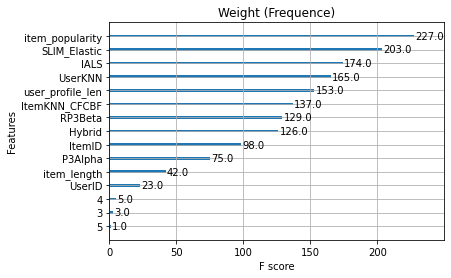

In [74]:
%matplotlib inline
from xgboost import plot_importance
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

#### Creating the dataframe with the predictions

In [75]:
user_recommendations_items = []
user_recommendations_user_id = []

for id in tqdm(target['id']):
    recommendations = hybrid_all.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))

100%|██████████| 41116/41116 [01:30<00:00, 455.36it/s]


In [76]:
test_dataframe = pd.DataFrame({"UserID":user_recommendations_user_id, "ItemID":user_recommendations_items})

In [77]:
ItemKNN_CFCBF_all = ItemKNN_CFCBF_Hybrid_Recommender(urm_all, icm_all)
ItemKNN_CFCBF_all.fit(**ItemKNN_CFCBF_params)

UserKNN_all = UserKNNCFRecommender(urm_all)
UserKNN_all.fit(**UserKNN_params)

P3Alpha_all = P3alphaRecommender(urm_all)
P3Alpha_all.fit(**P3Alpha_params)

other_algorithms_all = {
    "Hybrid": hybrid_all,
    "SLIM_Elastic": SLIM_Elastic_all,
    "RP3Beta": RP3Beta,
    "ItemKNN_CFCBF": ItemKNN_CFCBF_all,
    "UserKNN": UserKNN_all,
    "IALS": IALS,
    "P3Alpha": P3Alpha_all,
}

ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (19.9%) items with no features.
Similarity column 24507 (100.0%), 1621.68 column/sec. Elapsed time 15.11 sec
Similarity column 41629 (100.0%), 1595.61 column/sec. Elapsed time 26.09 sec
P3alphaRecommender: Similarity column 24507 (100.0%), 2468.40 column/sec. Elapsed time 9.93 sec


In [78]:
test_dataframe = test_dataframe.set_index('UserID')

for user_id in tqdm(target['id']):
    for rec_label, rec_instance in other_algorithms_all.items():
        
        item_list = test_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "UserID"})

100%|██████████| 41116/41116 [12:11<00:00, 56.22it/s]


In [79]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_all).indptr)
test_dataframe['item_popularity'] = item_popularity[test_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(urm_all).indptr)
test_dataframe['user_profile_len'] = user_popularity[test_dataframe["UserID"].values.astype(int)]

test_dataframe

,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len
0,0,88,0.858603,0.225797,0.197448,0.669624,2.989326,0.714361,0.040531,5016,66
1,0,99,0.696343,0.182745,0.163713,1.017144,11.227981,0.516253,0.079201,379,66
2,0,111,0.692986,0.227246,0.084482,0.591702,0.750476,0.582824,0.048149,648,66
3,0,108,0.668093,0.218287,0.085561,0.553165,1.113960,0.502094,0.049999,699,66
4,0,175,0.642713,0.214141,0.079379,0.351877,3.869202,0.398641,0.053071,1337,66
...,...,...,...,...,...,...,...,...,...,...,...
1439055,41628,2010,0.105127,0.028257,0.024824,0.125081,1.368649,0.051930,0.010317,84,23
1439056,41628,2262,0.100732,0.020391,0.037359,0.100870,0.890115,-0.003629,0.010663,33,23
1439057,41628,8589,0.100591,0.025593,0.027459,0.058114,0.680482,0.021612,0.016671,241,23
1439058,41628,1991,0.099506,0.026454,0.024137,0.134864,0.000000,0.045796,0.009319,66,23


In [80]:
# qui va messo stesso codice di prima

features_df = pd.DataFrame.sparse.from_spmatrix(icm_all)

test_dataframe = test_dataframe.set_index('ItemID').join(features_df, how='inner')
test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "ItemID"})

test_dataframe = test_dataframe.merge(icm_length_mapped, how="left")
test_dataframe['item_length'] = test_dataframe['item_length'].fillna(0).astype(int)

test_dataframe = test_dataframe.sort_values("UserID").reset_index()
test_dataframe.drop(columns = ['index'], inplace=True)
test_dataframe

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length
0,88,0,0.858603,0.225797,0.197448,0.669624,2.989326,0.714361,0.040531,5016,66,0.0,0.0,0.0,0.0,1.0,1.0,14
1,489,0,0.353746,0.084492,0.093340,0.202199,1.169173,0.340531,0.020668,1849,66,1.0,0.0,0.0,0.0,0.0,1.0,1
2,113,0,0.334711,0.078879,0.075057,0.848110,7.532577,0.643896,0.076749,1173,66,0.0,0.0,0.0,1.0,0.0,1.0,1
3,544,0,0.445981,0.136331,0.061757,0.729285,2.307708,0.568779,0.088551,801,66,0.0,0.0,0.0,0.0,1.0,1.0,14
4,111,0,0.692986,0.227246,0.084482,0.591702,0.750476,0.582824,0.048149,648,66,0.0,0.0,0.0,0.0,1.0,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439055,2026,41628,0.147914,0.047519,0.023995,0.128844,0.000000,0.031715,0.009165,64,23,0.0,0.0,0.0,0.0,0.0,0.0,0
1439056,2956,41628,0.198776,0.041094,0.047026,0.290263,6.194128,0.533923,0.016090,918,23,0.0,0.0,0.0,0.0,1.0,1.0,8
1439057,4529,41628,0.130937,0.040355,0.025788,0.108635,0.000000,-0.008604,0.008257,34,23,0.0,0.0,0.0,0.0,0.0,0.0,0
1439058,2656,41628,0.177156,0.051240,0.032070,0.160865,4.207815,0.167950,0.000000,385,23,0.0,0.0,0.0,1.0,0.0,1.0,1


In [81]:
X = test_dataframe

In [82]:
predictions = XGB_model.predict(X)
predictions

array([ 0.54007655, -0.71502   , -0.300681  , ..., -2.7608242 ,
       -1.0123451 , -2.6541162 ], dtype=float32)

In [83]:
reranked_dataframe = test_dataframe.copy()
reranked_dataframe['rating_xgb'] = pd.Series(predictions, index=reranked_dataframe.index)
reranked_dataframe

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length,rating_xgb
0,88,0,0.858603,0.225797,0.197448,0.669624,2.989326,0.714361,0.040531,5016,66,0.0,0.0,0.0,0.0,1.0,1.0,14,0.540077
1,489,0,0.353746,0.084492,0.093340,0.202199,1.169173,0.340531,0.020668,1849,66,1.0,0.0,0.0,0.0,0.0,1.0,1,-0.715020
2,113,0,0.334711,0.078879,0.075057,0.848110,7.532577,0.643896,0.076749,1173,66,0.0,0.0,0.0,1.0,0.0,1.0,1,-0.300681
3,544,0,0.445981,0.136331,0.061757,0.729285,2.307708,0.568779,0.088551,801,66,0.0,0.0,0.0,0.0,1.0,1.0,14,-0.129371
4,111,0,0.692986,0.227246,0.084482,0.591702,0.750476,0.582824,0.048149,648,66,0.0,0.0,0.0,0.0,1.0,1.0,8,0.466037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439055,2026,41628,0.147914,0.047519,0.023995,0.128844,0.000000,0.031715,0.009165,64,23,0.0,0.0,0.0,0.0,0.0,0.0,0,-2.651794
1439056,2956,41628,0.198776,0.041094,0.047026,0.290263,6.194128,0.533923,0.016090,918,23,0.0,0.0,0.0,0.0,1.0,1.0,8,-0.040634
1439057,4529,41628,0.130937,0.040355,0.025788,0.108635,0.000000,-0.008604,0.008257,34,23,0.0,0.0,0.0,0.0,0.0,0.0,0,-2.760824
1439058,2656,41628,0.177156,0.051240,0.032070,0.160865,4.207815,0.167950,0.000000,385,23,0.0,0.0,0.0,1.0,0.0,1.0,1,-1.012345


In [84]:
reranked_dataframe = reranked_dataframe.sort_values(['UserID','rating_xgb'], ascending=[True, False])
reranked_dataframe

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length,rating_xgb
5,99,0,0.696343,0.182745,0.163713,1.017144,11.227981,0.516253,0.079201,379,66,1.0,0.0,0.0,0.0,0.0,1.0,1,0.569593
0,88,0,0.858603,0.225797,0.197448,0.669624,2.989326,0.714361,0.040531,5016,66,0.0,0.0,0.0,0.0,1.0,1.0,14,0.540077
4,111,0,0.692986,0.227246,0.084482,0.591702,0.750476,0.582824,0.048149,648,66,0.0,0.0,0.0,0.0,1.0,1.0,8,0.466037
13,108,0,0.668093,0.218287,0.085561,0.553165,1.113960,0.502094,0.049999,699,66,1.0,0.0,0.0,0.0,0.0,1.0,1,0.351891
29,175,0,0.642713,0.214141,0.079379,0.351877,3.869202,0.398641,0.053071,1337,66,0.0,0.0,0.0,1.0,0.0,1.0,1,0.277329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439052,2042,41628,0.112287,0.032766,0.022698,0.110710,0.000000,0.045475,0.008008,58,23,0.0,0.0,0.0,0.0,0.0,0.0,0,-3.054165
1439044,1991,41628,0.099506,0.026454,0.024137,0.134864,0.000000,0.045796,0.009319,66,23,0.0,0.0,0.0,0.0,1.0,1.0,22,-3.147993
1439032,467,41628,0.110934,0.034066,0.020158,0.095976,0.763269,0.033318,0.012942,68,23,1.0,0.0,0.0,0.0,0.0,1.0,1,-3.160835
1439042,8589,41628,0.100591,0.025593,0.027459,0.058114,0.680482,0.021612,0.016671,241,23,1.0,0.0,0.0,0.0,0.0,1.0,1,-3.197847


# FInally the submission

In [85]:
def write_reranked_recommendations(file_name):
    recommendations = 'user_id,item_list'
    f = open(file_name + ".csv", "w")

    for id in tqdm(target['id']):
        recommendations_per_user = reranked_dataframe.loc[reranked_dataframe['UserID'] == id].ItemID.values[:10]

        recommendation_string = str(user_original_ID_to_index[user_original_ID_to_index==id].index.item()
                                    ) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(item_original_ID_to_index[item_original_ID_to_index==rec].index.item()) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [86]:
write_reranked_recommendations(file_name = "submission")

100%|██████████| 41116/41116 [03:51<00:00, 177.90it/s]


In [87]:
submission = pd.read_csv("submission.csv")
submission

,user_id,item_list
0,0,391 20 752 617 18484 2495 23 2488 56 107
1,1,6874 665 56 62 21 352 124 1689 23 61
2,2,121 7864 925 453 22415 1308 1311 750 21319 8819
3,3,20 21 352 7113 917 269 169 557 22752 58
4,4,23 80 68 21 124 64 56 541 436 2119
...,...,...
41111,41624,11552 22403 10221 7864 617 15711 13472 752 226...
41112,41625,56 23 53 25 60 393 1068 268 450 598
41113,41626,21 61 387 270 58 23 22619 393 25 124
41114,41627,1214 1754 17021 2803 1558 1561 4577 19705 1859...


## Sanity check

In [88]:
result_hybrid, _ = evaluator_test.evaluateRecommender(hybrid_train)
result_elastic, _ = evaluator_test.evaluateRecommender(SLIM_Elastic_train)
result_rp3b, _ = evaluator_test.evaluateRecommender(RP3Beta_train)
result_ials, _ = evaluator_test.evaluateRecommender(IALS_train)
result_itemKnn, _ = evaluator_test.evaluateRecommender(ItemKNN_CFCBF_train)
result_userKnn, _ = evaluator_test.evaluateRecommender(UserKNN_train)
result_p3a, _ = evaluator_test.evaluateRecommender(P3Alpha_train)


print("Hybrid: {}".format(result_hybrid['MAP'].item()))
print("SLIM Elastic: {}".format(result_elastic['MAP'].item()))
print("RP3Beta: {}".format(result_rp3b['MAP'].item()))
print("IALS: {}".format(result_ials['MAP'].item()))
print("ItemKNN_CFCBF: {}".format(result_itemKnn['MAP'].item()))
print("UserKNN: {}".format(result_userKnn['MAP'].item()))
print("P3Alpha: {}".format(result_p3a['MAP'].item()))

EvaluatorHoldout: Processed 40653 (100.0%) in 50.01 sec. Users per second: 813
EvaluatorHoldout: Processed 40653 (100.0%) in 38.15 sec. Users per second: 1066
EvaluatorHoldout: Processed 40653 (100.0%) in 22.19 sec. Users per second: 1832
EvaluatorHoldout: Processed 40653 (100.0%) in 30.92 sec. Users per second: 1315
EvaluatorHoldout: Processed 40653 (100.0%) in 22.62 sec. Users per second: 1797
EvaluatorHoldout: Processed 40653 (100.0%) in 42.45 sec. Users per second: 958
EvaluatorHoldout: Processed 40653 (100.0%) in 22.36 sec. Users per second: 1818
Hybrid: 0.028356867784215145
SLIM Elastic: 0.02805443886489457
RP3Beta: 0.025883070969595252
IALS: 0.02012584049518555
ItemKNN_CFCBF: 0.02463771978014404
UserKNN: 0.024393476886650327
P3Alpha: 0.02393646635344602


## Stats

In [89]:
noreranksubmission = pd.read_csv("submission_norerank.csv")

In [90]:
changed_item_count = 0

for user_id in submission['user_id']:
    default_items = noreranksubmission[noreranksubmission['user_id'] == user_id].item_list.values[0].split()
    reranked_items = submission[submission['user_id'] == user_id].item_list.values[0].split()
    
    new_items = list(set(reranked_items) - set(default_items))
    
    changed_item_count = changed_item_count + len(new_items)
    
n_users_to_recommend = len(target['id'])
n_recommended_items = n_users_to_recommend * 10

print("Changed {} items, {:.2f}% of total".format(changed_item_count, changed_item_count/n_recommended_items * 100))

Changed 84678 items, 20.59% of total


## Save models

In [91]:
SLIM_Elastic_all.save_model("used_models", "SLIM_Elastic_all.zip")
SLIM_Elastic_train.save_model("used_models", "SLIM_Elastic_train_validation.zip")

RP3Beta.save_model("used_models", "RP3Beta_all.zip")
RP3Beta_train.save_model("used_models", "RP3Beta_train_validation.zip")

IALS.save_model("used_models", "IALS_all.zip")
IALS_train.save_model("used_models", "IALS_train_validation.zip")

SLIMElasticNetRecommender: Saving model in file 'used_modelsSLIM_Elastic_all.zip'
SLIMElasticNetRecommender: Saving complete
SLIMElasticNetRecommender: Saving model in file 'used_modelsSLIM_Elastic_train_validation.zip'
SLIMElasticNetRecommender: Saving complete
RP3betaRecommender: Saving model in file 'used_modelsRP3Beta_all.zip'
RP3betaRecommender: Saving complete
RP3betaRecommender: Saving model in file 'used_modelsRP3Beta_train_validation.zip'
RP3betaRecommender: Saving complete
IALSRecommender: Saving model in file 'used_modelsIALS_all.zip'
IALSRecommender: Saving complete
IALSRecommender: Saving model in file 'used_modelsIALS_train_validation.zip'
IALSRecommender: Saving complete


In [92]:
!mkdir ../data
!cp used_models/* ../data
!cp submission.csv ..
!cp submission_norerank.csv ..

In [93]:
os.chdir("..")
!rm -r RecSys-2022-Challenge-Polimi

In [94]:
training_dataframe.to_csv("training_dataframe.csv")
test_dataframe.to_csv("test_dataframe.csv")